In [1]:
import scanpy as sc
import graph_tool.all as gt
import scnsbm
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('../../scRNA_paga/state_adata/MARSseq_minimize.h5ad')

<BarContainer object of 10 artists>

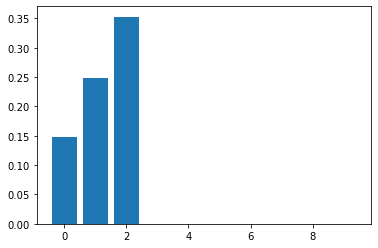

In [3]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

In [4]:
M=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(M, axis=1)

In [5]:
adata_affinity=adata[adata.obs.max_u < 1e-100]

Trying to set attribute `.uns` of view, copying.


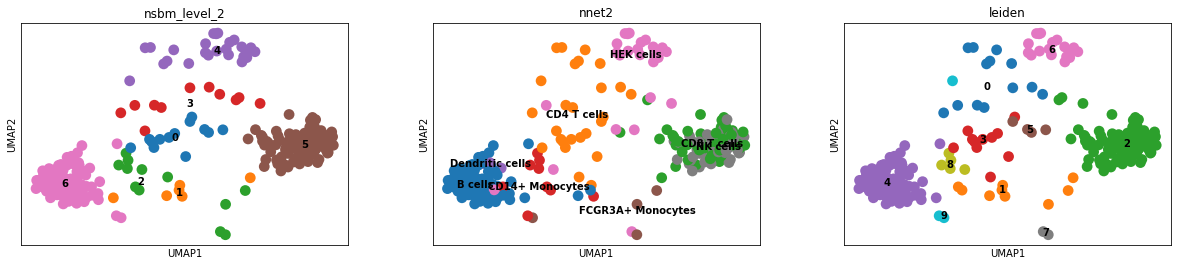

In [6]:
sc.pl.umap(adata_affinity,color=['nsbm_level_2','nnet2','leiden'], legend_loc='on data')

In [31]:
sc.tl.leiden(adata, resolution=0.7)

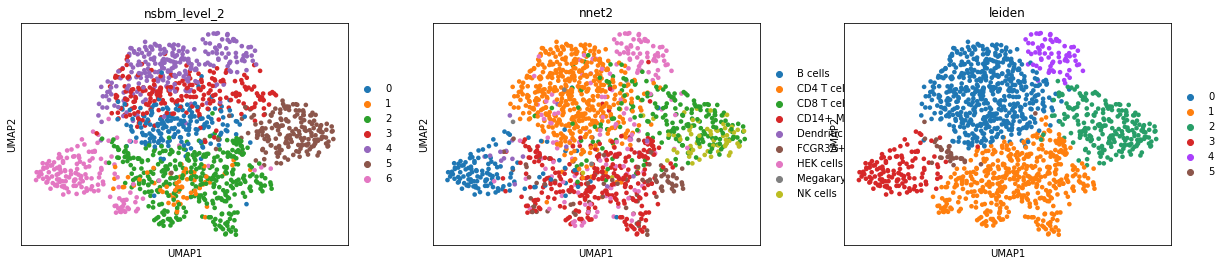

In [32]:
sc.pl.umap(adata,color=['nsbm_level_2','nnet2','leiden'])

In [8]:
level = '2'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [9]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

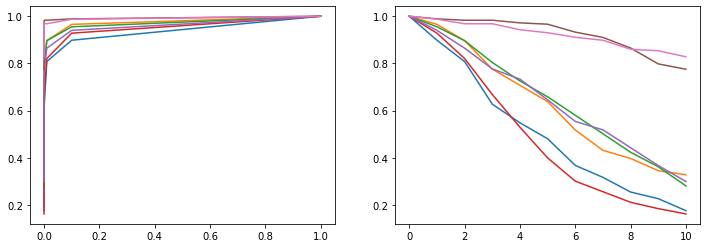

In [10]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot( x)

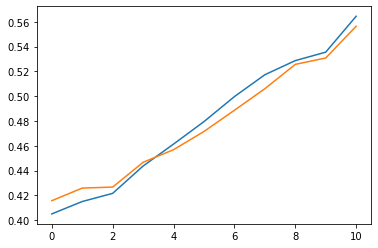

In [27]:
import sklearn
thr = np.array([ 10**-x for x in range(0, 11)])
mi_nsbm=list()
mi_leiden=list()
for i in thr:
    subdata=adata[adata.obs.max_u < i]
    mi_nsbm.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.nsbm_level_2, subdata.obs.nnet2))
    mi_leiden.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.leiden, subdata.obs.nnet2))
plot(mi_nsbm)
plot(mi_leiden)

In [28]:
MI=0.00
res=0
ciao=np.array(arange(0,1,0.01))
for i in range(len(ciao)):
    sc.tl.leiden(adata,resolution=ciao[i])
    mi=sklearn.metrics.adjusted_mutual_info_score(adata.obs.leiden, adata.obs.nsbm_level_2)
    if mi > MI:
        MI=mi
        res=ciao[i]
    else:continue
print(MI,res)

0.6391710269684094 0.58


In [4]:
import seaborn as sns

<ipython-input-12-53c679e11c4b>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
... storing 'flat' as categorical


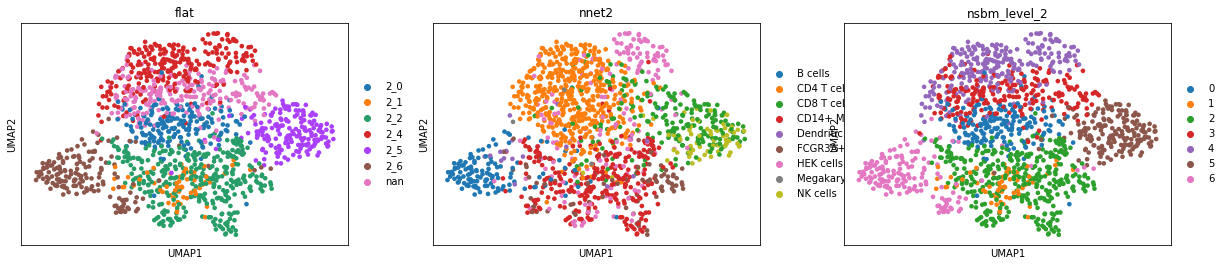

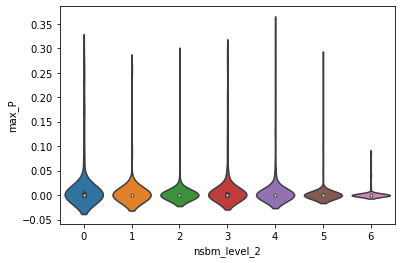

In [12]:
cdata=adata.copy()
flat=pd.Series()
level = str(2)
marginals = cdata.uns['nsbm']['cell_affinity'][level] 
group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])
n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)
D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
p = D / n_cell
p = p.T
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
for group in group_names:
    group_sign=mean(p[int(group)]-median)
    if group_sign>0:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
        a=a.replace(group,str(level+'_'+group))
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
        for i in cdata.uns['nsbm']['cell_affinity']:
            cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_affinities,axis=0)
        cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2',f'nsbm_level_{level}'])
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs, scale='width')

In [6]:
cdata=adata.copy()
flat=pd.Series()
level = str(1)
marginals = cdata.uns['nsbm']['cell_affinity'][level] 
group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])
n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)
D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
p = D / n_cell
p = p.T
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
for group in group_names:
    group_sign=mean(p[int(group)]-median)
    if group_sign>0.25:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
        a=a.replace(group,str(level+'_'+group))
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
        for i in cdata.uns['nsbm']['cell_affinity']:
            cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_affinities,axis=0)
        cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
            
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2',f'nsbm_level_{level}'])
#sns.barplot(data=-log10(marginals))
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.barplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs)

<ipython-input-6-64444e56cf82>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


ValueError: zero-size array to reduction operation maximum which has no identity

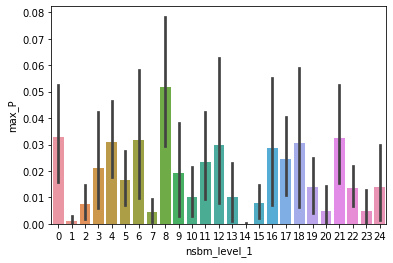

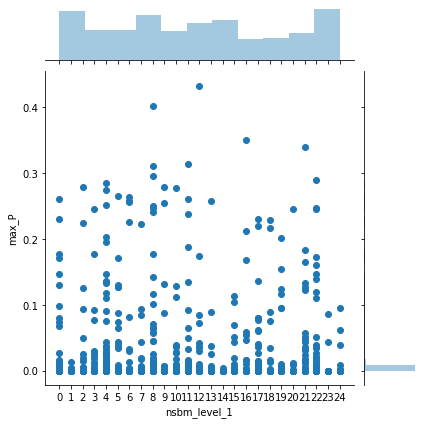

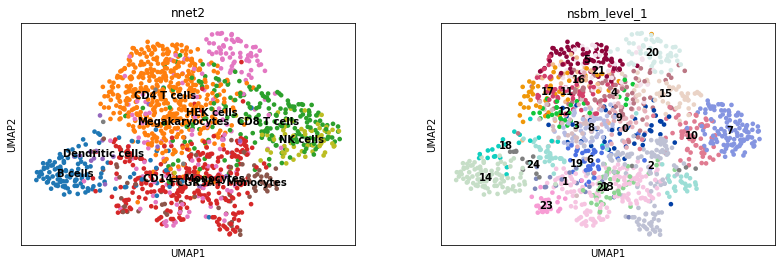

In [5]:
fdata=adata
level=str(1)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.barplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs)
sns.jointplot(x=f'nsbm_level_{level}' , y='max_P', data=fdata.obs)
sc.pl.umap(adata, color=['nnet2',f'nsbm_level_{level}'],legend_loc='on data')

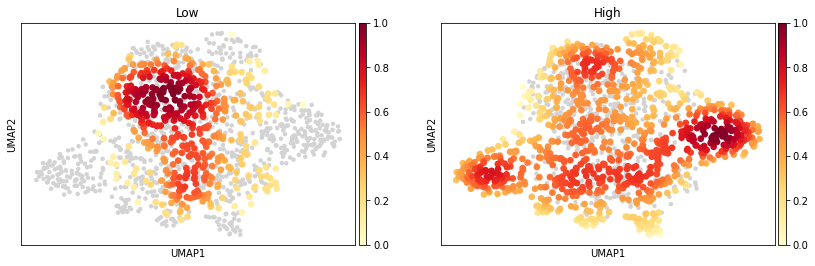

In [9]:
fdata=adata
level=str(2)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

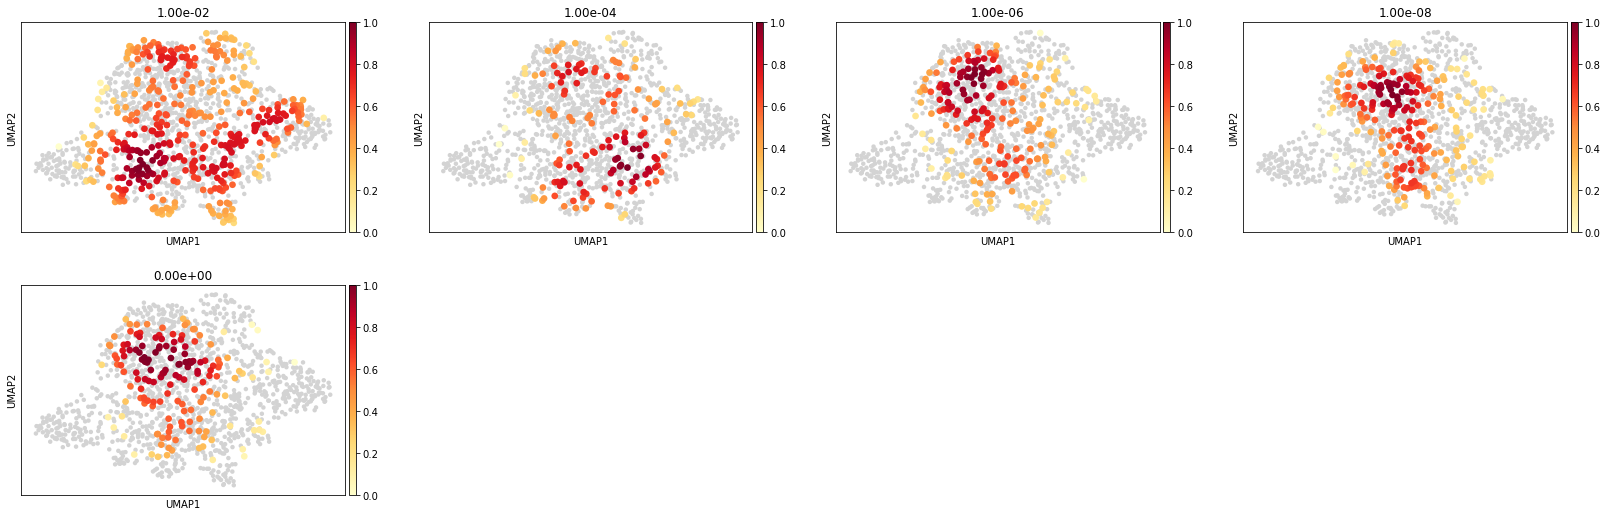

In [10]:
cuts = [0]+ [10**-x for x in range(0, 10, 2)][::-1]
d = pd.Categorical(pd.cut(1-np.max(marginals, axis=1), cuts))
d.rename_categories([f'{x:.2e}' for x in cuts[:-1]][::-1], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')